In [1]:
! pip3 install torch==2.2.2
#downgrade numpy to <2
! pip3 install numpy==1.26.4




Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Built me pytorch ANN that uses a a scikit wrapper for the pytorch model
#The model should have the following structure: hiddenlayers: 35, neuron per hidden layer: 110, optimizer: 'adamW', learning rate: 0.001, regularization:0.3
#The activation function should be leaky relu for the hidden layers and linear for the output layer. The input layer should have 146 neurons and the output layer should have 1 neuron
#The loss function is mse and the metric is mae, rmse and MAPE
#use NeuralNetRegressor from skorch to build the model
#epochs=150, batch_size=64

#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#load the data
data = pd.read_csv('one_hot_encoded.csv')



#split the data into features and target
X = data.drop('claim', axis=1)

feature_names = list(X.columns)

y = data['claim']

#split the data into training and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=69)
#create a pandas dataframe with X-train
X_train_pandas = pd.DataFrame(X_train, columns=feature_names)
# Second split: Split the 40% temporary set into 25% test and 15% evaluation
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=(0.25/0.4), random_state=69)

print(X_train.shape, y_train.shape)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)


print(X_train.shape, y_train.shape)
#print datatypes
print(X_train.dtype, y_train.dtype)
#print the type of list
print(type(X_train), type(y_train))


(8188, 146) (8188,)
(8188, 146) (8188,)
float64 float64
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the model class
class PyTorchModel(nn.Module):

        
    def __init__(self, input_dim, hidden_layers, neurons, optimizer, learning_rate, regularization):
        super(PyTorchModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, neurons))
        self.layers.append(nn.ReLU())
        
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(neurons, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
# Function to calculate MAE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

#convert y from pandas series to numpy array
y_train = np.asarray(y_train)
y_eval = np.asarray(y_eval)
y_test = np.asarray(y_test)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the PyTorch model
input_dim = X_train.shape[1]
hidden_layers = 35
neurons = 110
optimizer_name = 'adamW'
learning_rate = 0.001
regularization = 0.01

model = PyTorchModel(input_dim, hidden_layers, neurons, optimizer_name, learning_rate, regularization)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming this is a regression task, change if necessary

if optimizer_name.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
elif optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running_loss to zero at the start of each epoch

    # Iterate over batches of data from train_loader
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.view(-1, 1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss/len(val_loader)}")

# Evaluate on the training set
model.eval()
train_predictions = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predictions.extend(outputs.numpy())
train_predictions = np.array(train_predictions).flatten()
y_train_flat = np.array(y_train).flatten()  # Flatten if necessary
train_rmse = calculate_rmse(y_train_flat, train_predictions)
train_mae = calculate_mae(y_train_flat, train_predictions)
train_mape = calculate_mape(y_train_flat, train_predictions)

#evaluate on the validation set
val_predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        outputs = model(inputs)
        val_predictions.extend(outputs.numpy())
val_predictions = np.array(val_predictions).flatten()
y_eval_flat = np.array(y_eval).flatten()  # Flatten if necessary
val_rmse = calculate_rmse(y_eval_flat, val_predictions)
val_mae = calculate_mae(y_eval_flat, val_predictions)
val_mape = calculate_mape(y_eval_flat, val_predictions)

# Evaluate on the test set
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())
test_predictions = np.array(test_predictions).flatten()
y_test_flat = np.array(y_test).flatten()  # Flatten if necessary
test_rmse = calculate_rmse(y_test_flat, test_predictions)
test_mae = calculate_mae(y_test_flat, test_predictions)
test_mape = calculate_mape(y_test_flat, test_predictions)


# Print RMSE, MAE, and MAPE values for the training, validation, and test sets
print("Training Metrics:")
print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Train MAPE: {train_mape}%")
print("\nValidation Metrics:")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MAPE: {val_mape}%")
print("\nTest Metrics:")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")

Epoch [1/2], Loss: 154103408.96875
Validation Loss: 64778270.25
Epoch [2/2], Loss: 40369924.71875
Validation Loss: 36032219.0625
Training Metrics:
Train RMSE: 15173.214498870448
Train MAE: 10695.24639357067
Train MAPE: 1.4260378504284716%

Validation Metrics:
Validation RMSE: 6003.1835439099295
Validation MAE: 3835.03013740096
Validation MAPE: 0.4139822129691546%

Test Metrics:
Test RMSE: 6421.318276956707
Test MAE: 3968.2601682388563
Test MAPE: 0.4140563358213187%


In [ ]:
#save the model

torch.save(model, 'One_hot_ANN.pth')

In [ ]:
#get X-tensor of train_dataset
X_tensor = train_dataset.tensors[0]
y_tensor = train_dataset.tensors[1]

print(X_tensor)
print(y_tensor)


tensor([[-0.8955, -0.3409, -0.1685,  ..., -0.2325, -0.2985, -0.1385],
        [-0.3985,  0.9100, -0.1522,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.8795,  1.1308,  2.8334,  ..., -0.2325, -0.2985, -0.1385],
        ...,
        [-0.6115, -1.5183, -0.7202,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.4535, -0.1202,  0.5617,  ..., -0.2325, -0.2985, -0.1385],
        [ 1.3765, -0.9296, -0.2334,  ..., -0.2325, -0.2985, -0.1385]])
tensor([18246.5000,  6184.2998,  9748.9004,  ...,  4934.7002,  8824.0000,
        12129.5996])


In [ ]:
torch.no_grad()


#convert to tensor
example_instance = X.iloc[40]
print(example_instance)
example_instance = scaler.transform([example_instance])
print(example_instance)
example_instance = torch.tensor(example_instance, dtype=torch.float32)
print(example_instance)


print(model(example_instance).item())
print(y.iloc[40])


age                     18.0
weight                  41.0
bmi                     26.7
no_of_dependents         0.0
smoker                   0.0
                        ... 
job_title_Police         0.0
job_title_Politician     0.0
job_title_Singer         1.0
job_title_Student        0.0
job_title_Technician     0.0
Name: 40, Length: 146, dtype: float64
[[-1.53444884 -1.73906248 -0.57412949 -0.91432184 -0.49223989  0.79259407
   0.52174589  1.87185747  0.97825302 -0.97825302 -0.0948456  -0.07679066
  -0.0799459  -0.10423146 -0.06737448 -0.09679275 -0.08223486 -0.06737448
   0.26174611 -0.08519369 -0.14027193 -0.08663628 -0.11119351 -0.0664537
  -0.09218776 -0.10482848 -0.13799164 -0.08875749 -0.10119581 -0.09807016
  -0.08071591 -0.11615407 -0.14778197 -0.13799164 -0.09151166 -0.08805593
  -0.08945373 -0.09218776 -0.0954989  -0.11882506 -0.08298418 -0.07916859
  -0.08875749 -0.09743347 -0.09614792 -0.11342362 -0.12298462 -0.08591792
  -0.13093073 -0.0948456  -0.13189248 -0.07916859 -0

In [ ]:
import shap
shap.initjs()
#use deep explainer

torch.no_grad()

In [ ]:
e = shap.DeepExplainer(model, X_tensor)
print(e)




In [ ]:
shap_values = e.shap_values(example_instance, check_additivity=False)
print(shap_values)

print(shap_values.sum())


[[[-4.45391797e+03]
  [-2.29459564e+02]
  [-6.05230530e+02]
  [-6.30513245e+02]
  [-2.22527612e+03]
  [-1.83290726e+02]
  [-9.86701126e+01]
  [-3.99875305e+02]
  [ 4.76869164e+01]
  [ 4.72051735e+01]
  [-1.09038414e+02]
  [-4.55327415e+01]
  [-4.70054207e+01]
  [-4.65474396e+01]
  [-3.65643768e+01]
  [-4.28133621e+01]
  [-8.38426132e+01]
  [-2.90867081e+01]
  [-2.21443481e+02]
  [-3.49855919e+01]
  [-1.84380264e+01]
  [-4.53818464e+00]
  [-8.47517490e+00]
  [-4.91375589e+00]
  [-1.36158638e+01]
  [-6.66916370e+00]
  [-6.40313435e+00]
  [-5.97941589e+00]
  [-1.12368937e+01]
  [-1.56269808e+01]
  [-6.83088589e+00]
  [-8.22135639e+00]
  [-4.74988127e+00]
  [-6.62344551e+00]
  [-5.59279346e+00]
  [-6.95621777e+00]
  [-5.63176775e+00]
  [-5.59429073e+00]
  [-4.32974339e+00]
  [-8.98218346e+00]
  [-5.07266521e-01]
  [-8.13119507e+00]
  [-6.22888565e+00]
  [-7.95989990e+00]
  [-9.45957947e+00]
  [-6.57600307e+00]
  [-1.06179256e+01]
  [-3.79536796e+00]
  [-1.34316607e+01]
  [-6.53599596e+00]


In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=e.expected_value[0], data=X.iloc[40], feature_names=feature_names)
print(explanation)
print(explanation.values.shape)
print(explanation.base_values)

.values =
array([[[-4.45391797e+03],
        [-2.29459564e+02],
        [-6.05230530e+02],
        [-6.30513245e+02],
        [-2.22527612e+03],
        [-1.83290726e+02],
        [-9.86701126e+01],
        [-3.99875305e+02],
        [ 4.76869164e+01],
        [ 4.72051735e+01],
        [-1.09038414e+02],
        [-4.55327415e+01],
        [-4.70054207e+01],
        [-4.65474396e+01],
        [-3.65643768e+01],
        [-4.28133621e+01],
        [-8.38426132e+01],
        [-2.90867081e+01],
        [-2.21443481e+02],
        [-3.49855919e+01],
        [-1.84380264e+01],
        [-4.53818464e+00],
        [-8.47517490e+00],
        [-4.91375589e+00],
        [-1.36158638e+01],
        [-6.66916370e+00],
        [-6.40313435e+00],
        [-5.97941589e+00],
        [-1.12368937e+01],
        [-1.56269808e+01],
        [-6.83088589e+00],
        [-8.22135639e+00],
        [-4.74988127e+00],
        [-6.62344551e+00],
        [-5.59279346e+00],
        [-6.95621777e+00],
        [-5.631767

In [ ]:
#Respace the explanation.values from 1, 146, 1 to 1,146
print(explanation.values)
explanation.values = explanation.values.reshape(146)
print(explanation.values.shape)
print(explanation.values)


[[[-4.45391797e+03]
  [-2.29459564e+02]
  [-6.05230530e+02]
  [-6.30513245e+02]
  [-2.22527612e+03]
  [-1.83290726e+02]
  [-9.86701126e+01]
  [-3.99875305e+02]
  [ 4.76869164e+01]
  [ 4.72051735e+01]
  [-1.09038414e+02]
  [-4.55327415e+01]
  [-4.70054207e+01]
  [-4.65474396e+01]
  [-3.65643768e+01]
  [-4.28133621e+01]
  [-8.38426132e+01]
  [-2.90867081e+01]
  [-2.21443481e+02]
  [-3.49855919e+01]
  [-1.84380264e+01]
  [-4.53818464e+00]
  [-8.47517490e+00]
  [-4.91375589e+00]
  [-1.36158638e+01]
  [-6.66916370e+00]
  [-6.40313435e+00]
  [-5.97941589e+00]
  [-1.12368937e+01]
  [-1.56269808e+01]
  [-6.83088589e+00]
  [-8.22135639e+00]
  [-4.74988127e+00]
  [-6.62344551e+00]
  [-5.59279346e+00]
  [-6.95621777e+00]
  [-5.63176775e+00]
  [-5.59429073e+00]
  [-4.32974339e+00]
  [-8.98218346e+00]
  [-5.07266521e-01]
  [-8.13119507e+00]
  [-6.22888565e+00]
  [-7.95989990e+00]
  [-9.45957947e+00]
  [-6.57600307e+00]
  [-1.06179256e+01]
  [-3.79536796e+00]
  [-1.34316607e+01]
  [-6.53599596e+00]


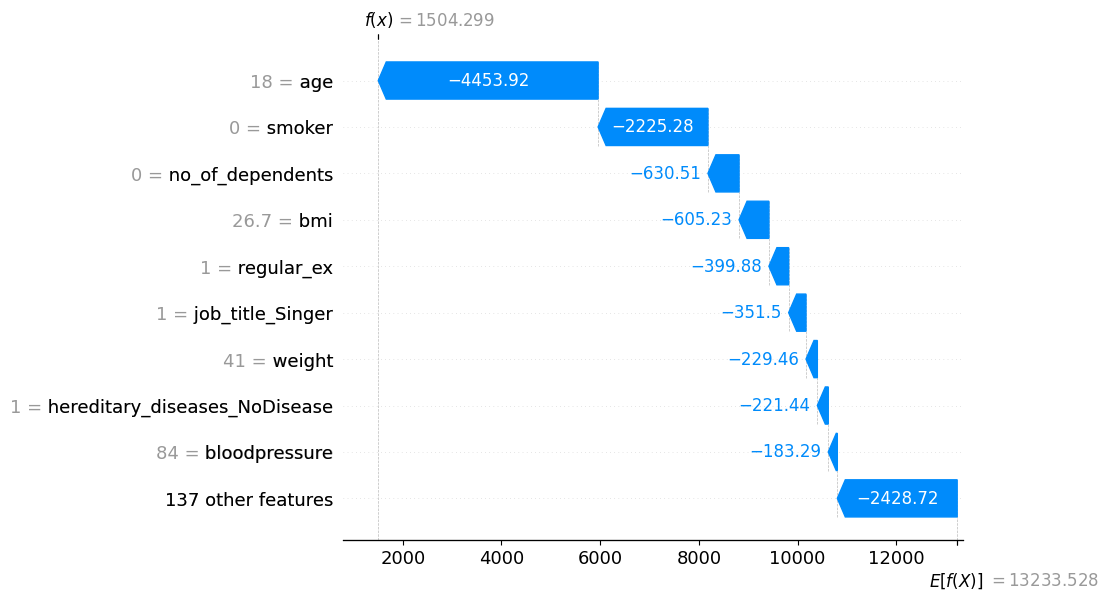

In [ ]:
#display all feature contribution in a waterfall plot
#print(X.iloc[0])
#print(explanation)
shap.waterfall_plot(explanation)
#print the prediction that shap stored








In [ ]:
#Partial Dependence Plot
import matplotlib.pyplot as plt

#create function to get all values for a a column
def get_column_values(column, X):
    return X[column].values

#function that gets all rows with a certain value for a certain column
def get_rows_with_value(column, value, X):
    return X[X[column] == value]

#function takes in a set of rows and then returns the average of the prediction
def get_average_prediction(rows):
    predictions = []
    for i in range(len(rows)):
        row = rows.iloc[i]
        row = scaler.transform([row])
        row = torch.tensor(row, dtype=torch.float32)
        prediction = model(row).item()
        predictions.append(prediction)
    return np.mean(predictions)

#function that returns a 2d array of value-average prediction pairs
def get_value_prediction_pairs(column, X):
    values = get_column_values(column, X)
    value_prediction_pairs = []
    for value in values:
        rows = get_rows_with_value(column, value, X)
        average_prediction = get_average_prediction(rows)
        value_prediction_pairs.append([value, average_prediction])
    return value_prediction_pairs

#plot the value prediction pairs
def plot_value_prediction_pairs(column, X):
    value_prediction_pairs = get_value_prediction_pairs(column, X)
    # Sorting the pairs to make the plot more coherent, especially if the values are numeric
    value_prediction_pairs.sort(key=lambda x: x[0])
    
    values = [pair[0] for pair in value_prediction_pairs]
    predictions = [pair[1] for pair in value_prediction_pairs]
    
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(values, predictions, marker='o', linestyle='-', color='b')  # Plot with markers and a line
    plt.title(f'Partial Dependence Plot for {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Average Prediction')  # Set y-axis label
    plt.grid(True)  # Enable grid for easier readability
    plt.show()  # Display the plot











In [ ]:
X_train_pandas_pdp = X_train_pandas
X_train_pandas_pdp.head()

#create a list of the average in very column
average_per_column = []
for column in X_train_pandas_pdp.columns:
    average = X_train_pandas_pdp[column].mean()
    average_per_column.append(average)
#print(average_per_column)

#get rid of the first entry
average_per_column = average_per_column
#print(feature_names[1:])
#transform back to pandas


non_explorable_columns = pd.DataFrame(X_train_pandas_pdp, columns=feature_names)
non_explorable_columns = non_explorable_columns.drop('age', axis=1) 
#display
non_explorable_columns.head()


#get unique age values
age_values = X_train_pandas_pdp['age'].unique()



age_values = pd.DataFrame(age_values, columns=['age'])

age_values.head()

#add age_values to non_explorable_columns
X_train_pandas_pdp = pd.concat([age_values, non_explorable_columns], axis=1)




NameError: name 'X_train_pandas' is not defined

In [ ]:
#Partial Dependence Plot
import matplotlib.pyplot as partial_dependence
X_train_pandas_pdp = X_train_pandas

#sort pandas data set according to a column, lowest at first
X_train_pandas_pdp = X_train_pandas_pdp.sort_values(by='age', ascending=True)

# Get the unique values in the 'age' column
non_age_columns = X_train_pandas_pdp.drop(columns=['age'])
# Get the average of the non-'age' columns
non_age_avg = non_age_columns.mean()

X_train_pandas_pdp['age'] = X_train_pandas_pdp['age'].fillna(non_age_avg)

# Fill missing values in the 'age' column with the average row values
X_train_pandas_pdp['age'] = X_train_pandas_pdp['age'].fillna(non_age_avg)
X_train_pandas_pdp.head(100)
#Group the data by the column
grouped_data = X_train_pandas_pdp.groupby('age')
#print thd groups
#for name, group in grouped_data:
    #print(name)
    #print(group)

#Scale each group
scaled_data = []
for name, group in grouped_data:
    group = scaler.transform(group)
    scaled_data.append(group)

#convert the list to a list of tensors
scaled_data = [torch.tensor(group, dtype=torch.float32) for group in scaled_data]

#calculate the average prediction for each group
average_predictions = []
for group in scaled_data:
    predictions = []
    for i in range(len(group)):
        row = group[i]
        row = torch.tensor(row, dtype=torch.float32)
        prediction = model(row).item()
        predictions.append(prediction)
    average_predictions.append(np.mean(predictions))


#plot the partial dependence plot
partial_dependence.plot(values, average_predictions)
partial_dependence.title('Partial Dependence Plot for age')
partial_dependence.xlabel('age')
partial_dependence.ylabel('Average Claim')
partial_dependence.grid(True)
partial_dependence.show()


KeyboardInterrupt: 